# Overview

This is my solution from the course project of IBM [Unsupervised Machine Learning](https://pt.coursera.org/learn/ibm-unsupervised-machine-learning) course. The Dataset used was the [Wine Data Set](https://archive.ics.uci.edu/ml/datasets/wine) downloaded from UCI Machine Learning Repository.

The dataset contains a chemical analysis of wines derived from three different cultivars. The features are:
- Alcohol
- Malic acid
- Ash
- Alcalinity of ash
- Magnesium
- Total phenols
- Flavanoids
- Nonflavanoid phenols
- Proanthocyanins
- Color intensity
- Hue
- OD280/OD315 of diluted wines
- Proline



The main objective is: **Use unsupervisioned learning to group similars wines**. Since the ideal number of clusters is is already known from business context, KMeans seems to be ideal for the task.

# Necessary packages

In [3]:
#core
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

#Auto EDA -- !pip install dataprep -- 
#from dataprep.eda import create_report

#Machine Learning
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from yellowbrick.cluster import KElbowVisualizer
from sklearn.decomposition import PCA

#Options
plt.style.use('seaborn-darkgrid')
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 100)

# Glimpse on Data

In [4]:
cols = ["alcohol", "malic_acid", "ash", "ash_alcalinity", "magnesium", "phenols",
        "flavanoids", "non_flavanoids", "proanthocyanins", "color_intensity", "hue","OD_ratio", "proline"]

In [5]:
PATH = "../data/"

In [ ]:
#loading dataframe
df_raw = pd.read_csv(PATH+"wine.data", names = cols).reset_index(drop = True)

#create a copy to avoid edit raw data 
df = df_raw.copy()

In [7]:
df.head()

,alcohol,malic_acid,ash,ash_alcalinity,magnesium,phenols,flavanoids,non_flavanoids,proanthocyanins,color_intensity,hue,OD_ratio,proline
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [ ]:
df.tail()

,alcohol,malic_acid,ash,ash_alcalinity,magnesium,phenols,flavanoids,non_flavanoids,proanthocyanins,color_intensity,hue,OD_ratio,proline
173,13.71,5.65,2.45,20.5,95,1.68,0.61,0.52,1.06,7.7,0.64,1.74,740
174,13.40,3.91,2.48,23.0,102,1.80,0.75,0.43,1.41,7.3,0.70,1.56,750
175,13.27,4.28,2.26,20.0,120,1.59,0.69,0.43,1.35,10.2,0.59,1.56,835
176,13.17,2.59,2.37,20.0,120,1.65,0.68,0.53,1.46,9.3,0.60,1.62,840
177,14.13,4.10,2.74,24.5,96,2.05,0.76,0.56,1.35,9.2,0.61,1.60,560


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   alcohol          178 non-null    float64
 1   malic_acid       178 non-null    float64
 2   ash              178 non-null    float64
 3   ash_alcalinity   178 non-null    float64
 4   magnesium        178 non-null    int64  
 5   phenols          178 non-null    float64
 6   flavanoids       178 non-null    float64
 7   non_flavanoids   178 non-null    float64
 8   proanthocyanins  178 non-null    float64
 9   color_intensity  178 non-null    float64
 10  hue              178 non-null    float64
 11  OD_ratio         178 non-null    float64
 12  proline          178 non-null    int64  
dtypes: float64(11), int64(2)
memory usage: 18.2 KB


I always like to start the analysis with an auto EDA tool to give a first look on data and and get quick insights. Here I use [dataprep](https://dataprep.ai/) for this purpose.

In [ ]:
#this code export a html file named wine_cluster_job with dataprep output which can be opened locally by any browser 
report = create_report(df, title='Wine Cluster')
report.save("wine_cluster_job.html")

Report has been saved to Wine_cluster_job.html!


From EDA it's possible to get some insigths about the data:
- Some features have a small number of outliers witch alter their ditribution
- Malic acid had, magnesium, color_intensity and proline had a right long tail
- There some redundance in features, maybe because the overlap in them, eg: flavanoids is a fenol.

# Outliers

Since the number of outilers is small and K-means is highly sensitve to them the strategy was drop them with IQR method.

In [5]:
def drop_outliers(df):
  copy = df.copy()

  for col in copy.columns:

    q1 = copy[col].quantile(0.25)
    q3 = copy[col].quantile(0.75)
    IQR = q3 - q1

    upper = q3 + 1.5 * IQR
    lower = q1 - 1.5 * IQR

    outliers = copy[(copy[col] > upper) | (copy[col] < lower)]
    copy.drop(outliers.index, axis = 0, inplace = True)
    print(f"{col} - {len(outliers)} outliers")
  
  copy = copy.reset_index(drop = True)
  return copy  
 

In [6]:
df = drop_outliers(df)

alcohol - 0 outliers
malic_acid - 3 outliers
ash - 3 outliers
ash_alcalinity - 2 outliers
magnesium - 3 outliers
phenols - 0 outliers
flavanoids - 0 outliers
non_flavanoids - 0 outliers
proanthocyanins - 2 outliers
color_intensity - 3 outliers
hue - 1 outliers
OD_ratio - 0 outliers
proline - 0 outliers


In [7]:
#We removed 17 outliers
df_raw.shape[0] - df.shape[0]

17

# Dealing with Skew

To make the features more normal, I log transform those with a high skew observed on AutoEDA.

In [8]:
to_transform = ["malic_acid", "magnesium", "proline", "color_intensity"]

#applying transformation on specifics features
for col in to_transform:
  df[col] = np.log1p(df[col])

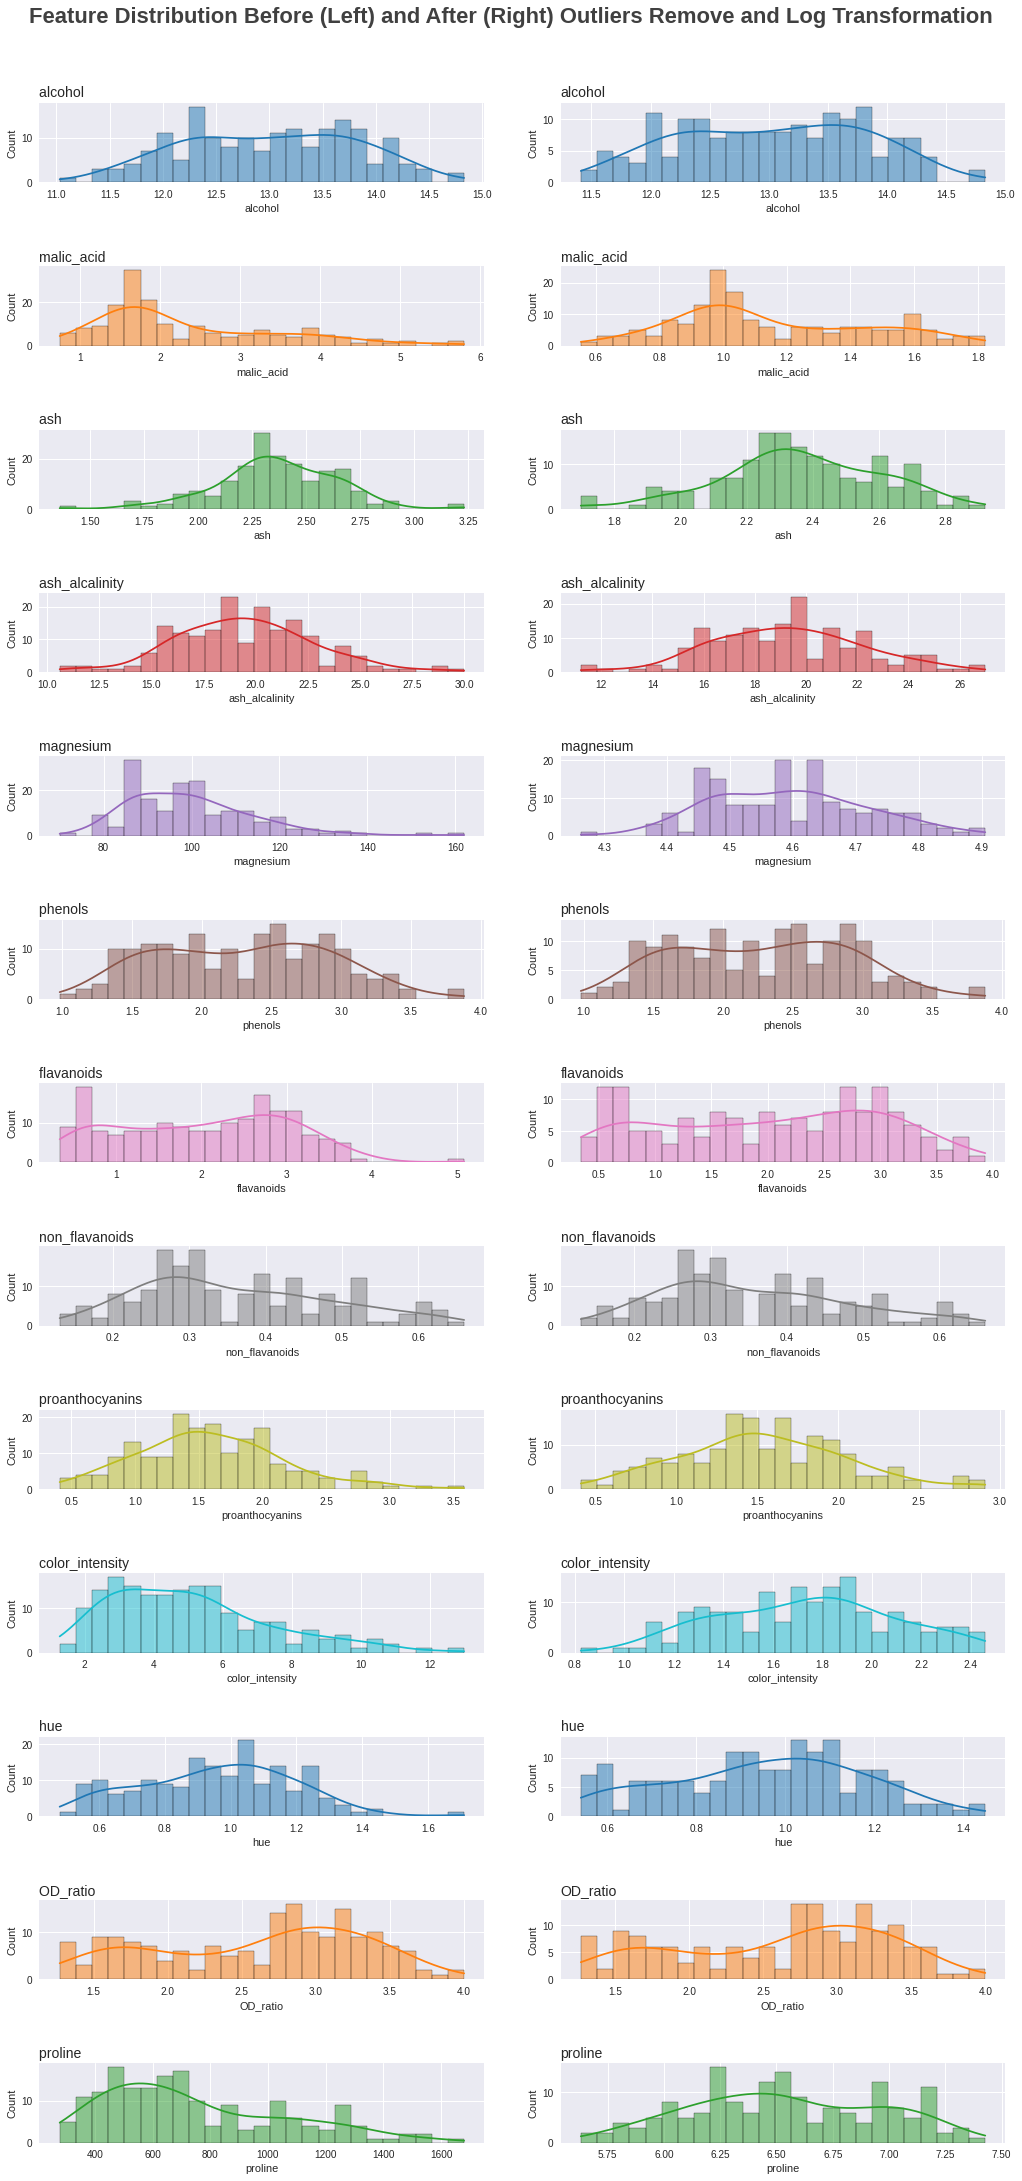

In [9]:
#visualize the result of transformation and outliers remotion
colors = sns.color_palette('tab10', len(df.columns))

fig, ax = plt.subplots(df.shape[1], 2, figsize = (15,30))
plt.suptitle('Feature Distribution Before (Left) and After (Right) Outliers Remove and Log Transformation', fontsize = 22, color = '#404040', fontweight = 600, y = 1.02)

for idx, col in enumerate(df.columns):
  sns.histplot(data = df_raw, x = col, bins = 25, kde = True, color = colors[idx], ax = ax[idx][0],)
  sns.histplot(data = df, x = col, bins = 25, kde = True, color = colors[idx],  ax = ax[idx][1],)

  ax[idx][0].set_title(f'{col} ', loc = "left", fontsize = 14, fontweight = 200)
  ax[idx][1].set_title(f'{col}', loc = "left", fontsize = 14, fontweight = 200)


fig.tight_layout(pad=3)

# Correlation

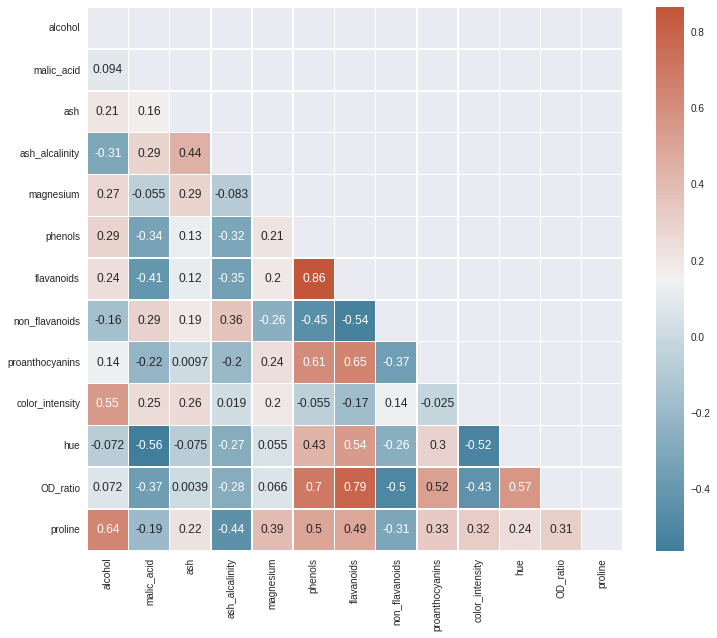

In [94]:
#calculate pearson correlation
corr = df_raw.corr()

#mask to hide the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

#colors to heatmap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

fig, ax = plt.subplots(figsize = (12,10))
sns.heatmap(corr, mask=mask, linewidths=.5, annot = True, ax = ax, cmap = cmap);

Since phenol is a wide group of chemical components which include flavanoids and anthocyanins and are moderate correlated with others features I will make the clusters without this feature.

In [10]:
df = df.drop("phenols", axis = 1)

# Clustering With KMeans

As KMeans is a method based on distance it's necessary to Scale the data before applying it to data.

The business context says that the number of clusters should be three since it's the number of cultivars. Here, I will try the Elbow method to see if the ideal number of clusters match with the expectation.

In [11]:
#scalling dataset with StandardScaler
scaler = MinMaxScaler(feature_range = (0,1))
df_scale = pd.DataFrame(scaler.fit_transform(df), columns = df.columns)

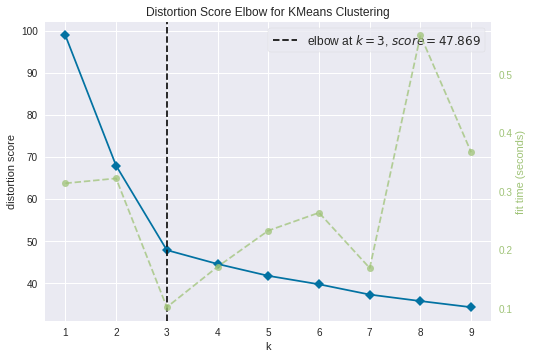

In [12]:
#applying Elbow Method to verify the ideal number os clusters
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,10)) #calculate distortion score for a range 1-10 of clusters

visualizer.fit(df_scale)       
visualizer.show();        

The results from Elbow match with what is expected according to the business context. So, the number of clusters choiced is three.

In [13]:
#training the KMeans and appending the results to DataFrame

model = KMeans(n_clusters = 3, init = "k-means++", random_state = 42)
clusters = model.fit_predict(df_scale)
df["cluster"] = clusters

# Interpreting the clusters

First, to visualize the clusters i will use PCA to combinate the features in two components to be possible vizualize in a two dimensional plot.

Again, as PCA is an unsupervisioned model it's not necessarious fornecer the routuels

In [14]:
pca = PCA(n_components = 2, random_state = 42)

components = pd.DataFrame(pca.fit_transform(df_scale), columns = ["x","y"])
components["cluster"] = clusters

In [118]:
components.head()

,x,y,cluster
0,-0.466417,0.718154,2
1,-0.363636,0.342790,2
2,-0.360181,0.528867,2
3,-0.431440,0.931878,2
4,-0.123116,0.278493,2


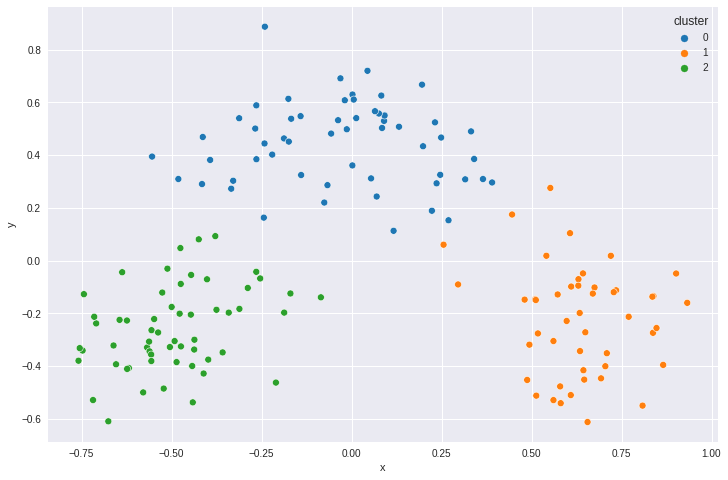

In [15]:
fig, ax = plt.subplots(figsize = (12,8))
sns.scatterplot(data = components, x = "x", y = "y", hue = "cluster", palette = colors[0:3]);

It's clearly possible to notice that the clusters are distinct and the grouping seems to make sense

In [17]:
df_scale["cluster"] = clusters
df_cluster = df_scale.groupby("cluster").mean()

In [18]:
df_cluster

,alcohol,malic_acid,ash,ash_alcalinity,magnesium,flavanoids,non_flavanoids,proanthocyanins,color_intensity,hue,OD_ratio,proline
cluster,,,,,,,,,,,,
0,0.248076,0.360792,0.457003,0.572396,0.390251,0.484924,0.426349,0.468351,0.333189,0.573087,0.575027,0.307148
1,0.498071,0.676051,0.572899,0.617964,0.522944,0.130978,0.604175,0.265362,0.736456,0.183540,0.156886,0.437843
2,0.682979,0.415951,0.609433,0.366200,0.632739,0.734301,0.295929,0.588140,0.633976,0.569693,0.692243,0.760570


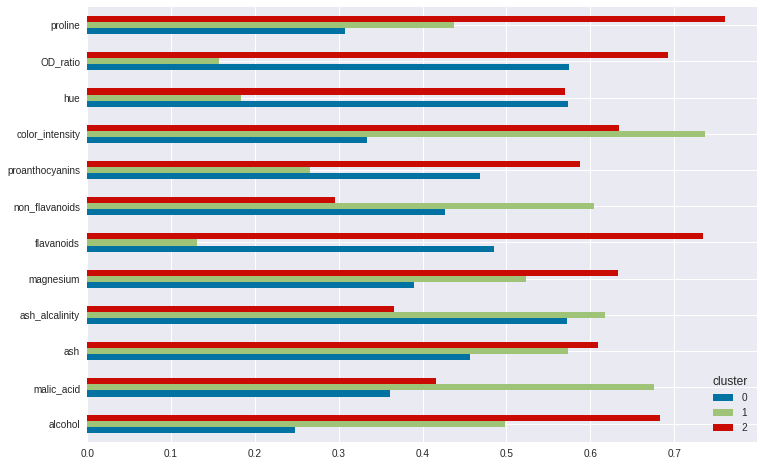

In [23]:
df_cluster.T.plot(kind = "barh", figsize = (12,8));

- Cluster 2: Wines with higher amount of antioxidant compounds like proline, flavanoids and proanthocyanins. Also, this group had a higher amount of magnesium which is a stress-protectant factor. These characteristics indicate that this group can bring health benefits. 

- Cluster 0

** continue



